<a href="https://colab.research.google.com/github/isiaqraheem/Disaster_tweets/blob/main/Disaster_sentiment_analysis_submissions_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#sentiment analysis of disaster tweets

Workflow
*   Exploratory data analysis
*   Buliding the model
*   Model evaluation










Exploratory Data analysis


In [ ]:
#importing the required libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
import gensim
import string
import spacy
from gensim.utils import simple_preprocess
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU,SimpleRNN
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import lightgbm as lgb
from keras.models import Model
import gensim.downloader as api
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, Sequential

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
train_df = pd.read_csv('gdrive/My Drive/Disaster_tweet.csv',sep = ',' ,encoding_errors='ignore')

test_df = pd.read_csv('gdrive/My Drive/Disaster_tweet_test.csv',sep = ',' ,encoding_errors='ignore')


In [ ]:
print('There are {} rows and {} columns in train_df'.format(train_df.shape[0],train_df.shape[1]))


There are 7613 rows and 5 columns in train_df


In [ ]:
train_df['target']

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [ ]:
#checking the number of missing values
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [ ]:
# number of duplicated train and test data
train_df["text"].isin(test_df["text"]).value_counts()

False    7507
True      106
Name: text, dtype: int64

In [ ]:
# merging the test data and  train data
merged_df = pd.concat([train_df, test_df], axis=0)
merged_df # train data would be above the test data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


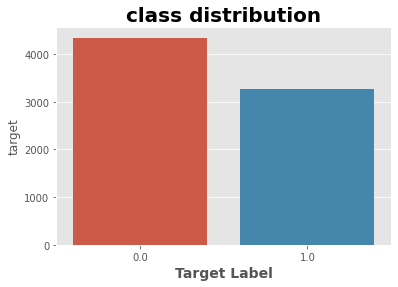

In [ ]:
# Ditsribution of our label
x=merged_df.target.value_counts()
sns.barplot(x.index,x)
plt.xlabel('counts')
plt.title("class distribution", size=20, weight="bold")
plt.xlabel("Target Label", size=14, weight="bold")
plt.show()

There is class imbalance in the data. There are more tweets with class zero(No disaster) compare to class one(disaater)

In [ ]:
# random examples of disaster tweets 
merged_df[merged_df["target"]==1].iloc[np.random.randint(0, 4000), -2]  # will give a sample of disaster tweet

'Incredulous at continued outcry of welfare being a waste of taxpayers money but never similar objection to ??100bn on nuclear weapons'

In [ ]:
# random examples of non-disaster tweets 
merged_df[merged_df["target"]==0].iloc[np.random.randint(0, 4000), -2]  # will give a sample of non disaster tweet

"Woke up to Drake body bagging Meek again!! Meek u can't out spit ya girlfriend... Just lay down Man.... NOT Right... http://t.co/6CraEKc9wb"

Percentage of missing values 

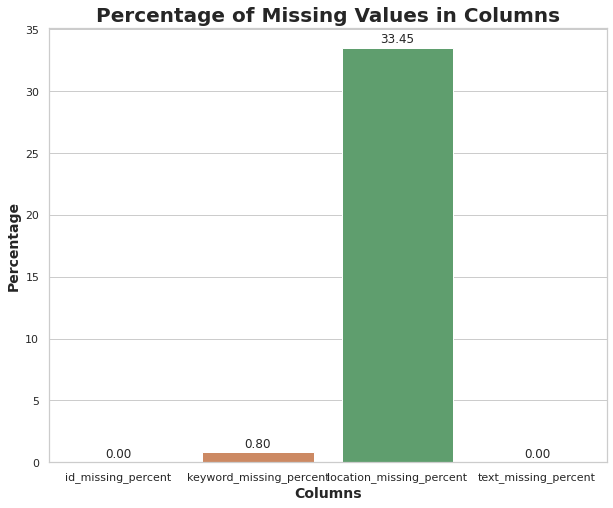

In [ ]:
# creating a new dataframe for missing values percentage
missing_values = dict(zip([col+"_missing_percent" for col in merged_df.columns if col != "target"],
                          [round(100*merged_df[col].isnull().sum()/len(merged_df), 2) for col in merged_df.columns
                           if col != "target"]))
missing_values_df = pd.DataFrame(missing_values, index=[0])
missing_values_df = missing_values_df.melt(var_name= "columns", value_name= "percentage")

# plotting missing values chart
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="percentage", data=missing_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Percentage of Missing Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.show()

Viewing the locatons in the tweets

In [ ]:
# creating a new dataframe with value counts of each location
locations= merged_df["location"].value_counts().sort_values(ascending=False)
locations_df= pd.DataFrame(dict(zip(locations.index, locations.values)), index=[0]).\
                                melt(var_name="location", value_name="unique_counts")
locations_df.loc[:10]

,location,unique_counts
0,USA,141
1,New York,109
2,United States,65
3,London,58
4,Canada,42
5,Nigeria,40
6,Worldwide,35
7,India,35
8,"Los Angeles, CA",34
9,UK,33


In [ ]:
# replacing some names from locations to be all countries
replace_names= {
    "USA":"United States",
    "New York":"United States",
    "Los Angeles": "United States",
    "Los Angeles, CA":"United States",
    "Washington, DC": "United States",
    "San Francisco": "United States",
    "San Francisco, CA": "United States",
    "Chicago, IL": "United States",
    "Chicago": "United States",
    "New York, NY": "United States",
    "NYC": "United States",
    "Florida": "United States",
    "London": "UK",
    "United Kingdom": "UK",
    "Mumbai": "India",
    "California": "United States",
    "California, USA": "United States",
    "Toronto": "Canada",
    "Washington, D.C.": "United States",
    "Everywhere": "Worldwide",
    "Seattle": "United States",
    "ss": "Worldwide"
}

countries = merged_df["location"].replace(replace_names).value_counts().sort_values(ascending=False)
countries_df= pd.DataFrame(dict(zip(countries.index, countries.values)), index=[0]).\
                                melt(var_name="country", value_name="unique_counts")
# Note: Counts may not be accurate because not all area's have been replaced! 
countries_df.loc[:10]

,country,unique_counts
0,United States,627
1,UK,117
2,Worldwide,64
3,India,63
4,Canada,58
5,Nigeria,40
6,Kenya,32
7,Australia,25
8,Ireland,15
9,Indonesia,15


In [ ]:
# A world plot with each of these locations highlighted with a heatmap displaying area's with higher unique counts
data = {
    "locations": countries_df.loc[:10, "country"],
    "locationmode": "country names",
    "z": countries_df.loc[:10, "unique_counts"],
    "colorscale": "Rainbow",
    "text": countries_df.loc[:10, "country"],
    "type": "choropleth",
    "colorbar": {"title": "Unique Counts", "len": 200, "lenmode":"pixels"}
}

layout = go.Layout(title_text= "<b>Tweet Locations of Top 10 Countries</b>",
                   geo= dict(scope= "world"))

fig = go.Figure(data=[data], layout=layout)
fig.update_layout(title_x=0.5)
fig.show()

finding the number of tweets in each location

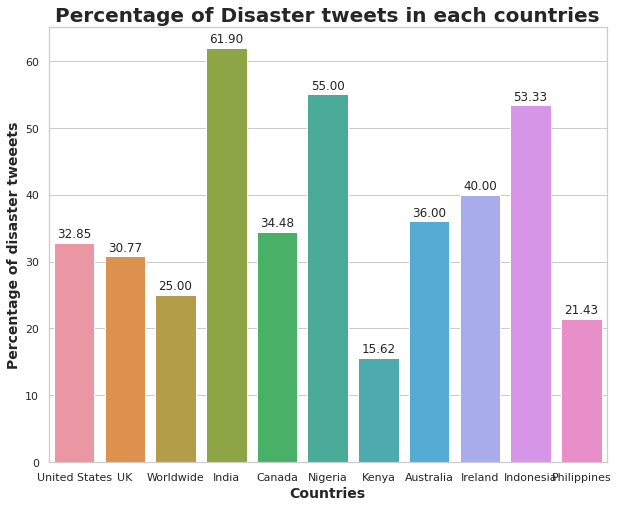

In [ ]:
# creating new dataframe to replace the names we changed
df = merged_df.copy()
df["location"].replace(replace_names, inplace=True)

# count the number of disaster tweets in each location
country_disaster_tweets = df[df["location"].isin(countries_df.loc[:10, "country"])].groupby("location")["target"].sum()
country_disaster_tweets_df = pd.merge(left=countries_df, right=country_disaster_tweets, left_on="country", right_on="location")

# renaming target column
country_disaster_tweets_df.rename(columns={"target":"disaster_tweets"}, inplace=True)
country_disaster_tweets_df["percent_disaster_tweets"] = round(100 * country_disaster_tweets_df["disaster_tweets"]\
                                                              / country_disaster_tweets_df["unique_counts"], 2)
# plotting the percentages
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="country", y="percent_disaster_tweets", data=country_disaster_tweets_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Percentage of Disaster tweets in each countries", size=20, weight="bold")
plt.xlabel("Countries", size=14, weight="bold")
plt.ylabel("Percentage of disaster tweeets", size=14, weight="bold")
plt.show()

Number of characters in tweets

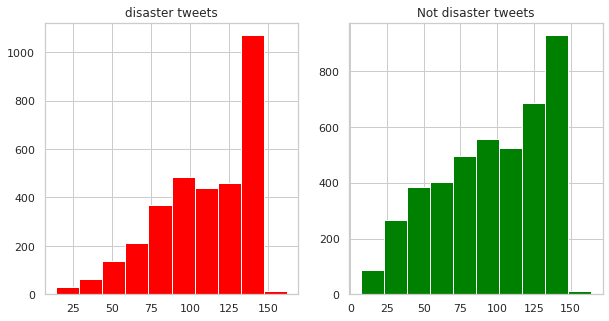

In [ ]:
ig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
num_characters=merged_df[merged_df['target']==1]['text'].str.len()
ax1.hist(num_characters,color='red')
ax1.set_title('disaster tweets')
num_characters=merged_df[merged_df['target']==0]['text'].str.len()
ax2.hist(num_characters,color='green')
ax2.set_title('Not disaster tweets')
plt.show()

The distribution of character seems to be the same in both tweets with characters between 120: 140 being the most common

Number of words in a tweet

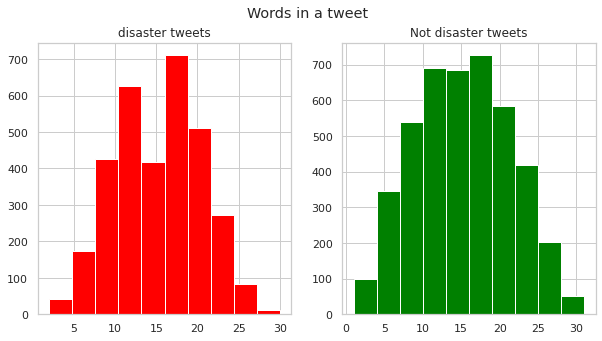

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
num_words=merged_df[merged_df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(num_words,color='red')
ax1.set_title('disaster tweets')
num_words=merged_df[merged_df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(num_words,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

In [ ]:
def create_corpus(target):
    """ List of words in the tweeet"""
    words_list=[]
    
    for x in merged_df[merged_df['target']==target]['text'].str.split():
        for i in x:
            words_list.append(i)
    return words_list

In [ ]:
words_list = create_corpus(0)
print(words_list[:100])



["What's", 'up', 'man?', 'I', 'love', 'fruits', 'Summer', 'is', 'lovely', 'My', 'car', 'is', 'so', 'fast', 'What', 'a', 'goooooooaaaaaal!!!!!!', 'this', 'is', 'ridiculous....', 'London', 'is', 'cool', ';)', 'Love', 'skiing', 'What', 'a', 'wonderful', 'day!', 'LOOOOOOL', 'No', 'way...I', "can't", 'eat', 'that', 'shit', 'Was', 'in', 'NYC', 'last', 'week!', 'Love', 'my', 'girlfriend', 'Cooool', ':)', 'Do', 'you', 'like', 'pasta?', 'The', 'end', 'has', 'come', '!', 'We', 'always', 'try', 'to', 'bring', 'the', 'heavy.', '#metal', '#RT', 'http://t.co/YAo1e0xngw', 'Crying', 'out', 'for', 'more!', 'Set', 'me', 'ablaze', 'On', 'plus', 'side', 'LOOK', 'AT', 'THE', 'SKY', 'LAST', 'NIGHT', 'IT', 'WAS', 'ABLAZE', 'http://t.co/qqsmshaJ3N', '@PhDSquares', '#mufc', "they've", 'built', 'so', 'much', 'hype', 'around', 'new', 'acquisitions', 'but', 'I', 'doubt', 'they']


Visualising the stop words in non disaster tweets


In [ ]:
#stop words count 
import nltk
nltk.download('stopwords')
dic=defaultdict(int)
stop = set(stopwords.words("english"))
for word in words_list:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<BarContainer object of 10 artists>

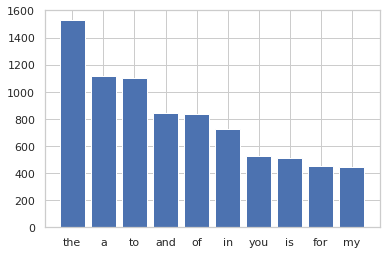

In [ ]:
x,y=zip(*top)
plt.bar(x,y)

Visualising class 1 tweets

In [ ]:
words_list_1 = create_corpus(1)

In [ ]:
dic=defaultdict(int)
stop = set(stopwords.words("english"))

for word in words_list_1:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

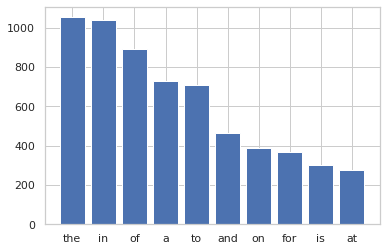

In [ ]:
x,y=zip(*top)
plt.bar(x,y)

Analysing punctuations

<BarContainer object of 20 artists>

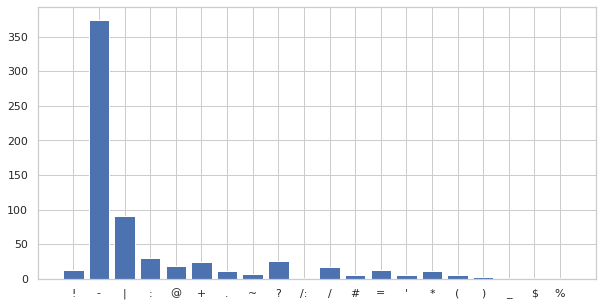

In [ ]:
# punctuations in disaster tweets
plt.figure(figsize=(10,5))
word_lists=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (words_list):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

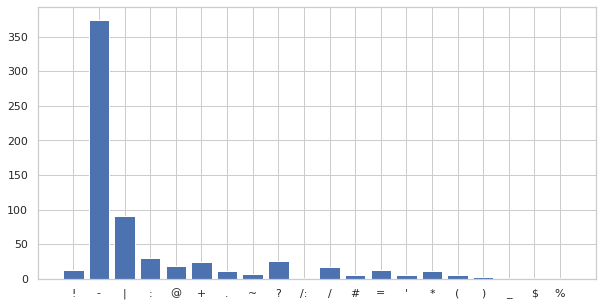

In [ ]:
# punctuations in non disaster tweets
plt.figure(figsize=(10,5))
word_lists=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (words_list):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

Ngram analysis (checking the most common 2 letter words(N =2) in the tweets)


In [ ]:
def most_common_2_letter_words(words_list, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(words_list)
    bag_of_words = vec.transform(words_list)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

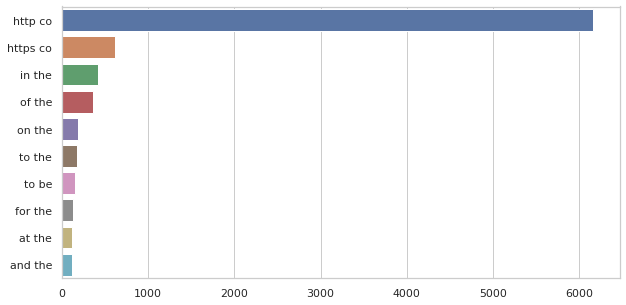

In [ ]:
plt.figure(figsize=(10,5))
bigrams=most_common_2_letter_words(merged_df['text'])[:10]
x,y=map(list,zip(*bigrams))
sns.barplot(x=y,y=x)

visualising the keywords in the tweets

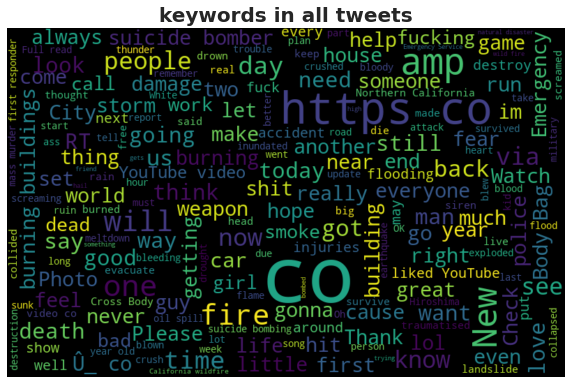

In [ ]:
# getting all the keywords from the tweets
key_tweets = " ".join([word for word in merged_df["text"]])

# visualizing tweets
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(key_tweets)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("keywords in all tweets", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

keywords in disasater tweets

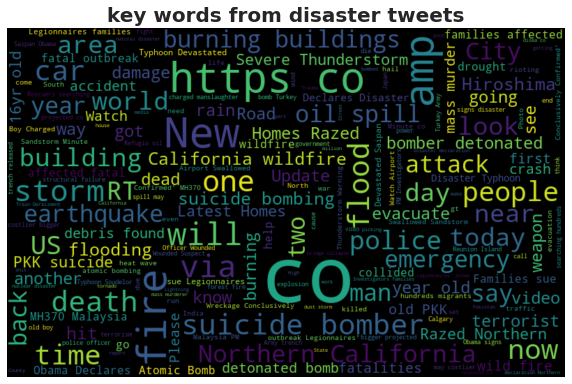

In [ ]:
key_disaster_tweets = " ".join([word for word in merged_df[merged_df["target"]==1]["text"]])

# visualizing tweets
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(key_disaster_tweets)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("key words from disaster tweets", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Keywords in non disaster tweets

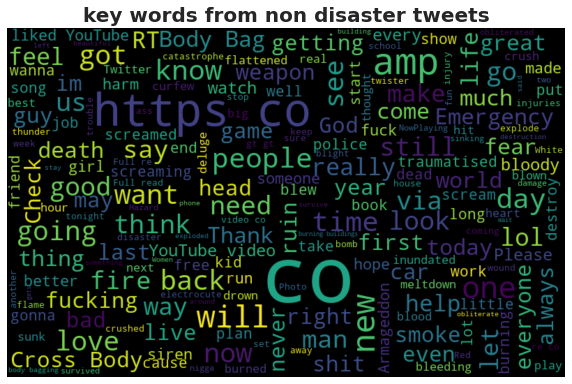

In [ ]:
key_non_disaster_tweets = " ".join([word for word in merged_df[merged_df["target"]==0]["text"]])

# visualizing tweets
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(key_non_disaster_tweets)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("key words from non disaster tweets", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Models


#model:1 Naive Bayes (Base Model)



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn import metrics


In [ ]:
X =train_df['text']
y= train_df['target'].values
# split the data into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model1 = make_pipeline(TfidfVectorizer(), MultinomialNB()) 

In [ ]:
model1.fit(X_train, y_train) 

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [ ]:
y_pred_classes = model1.predict(X_test)

print("multinomial Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred_classes)*100)

multinomial Naive Bayes model accuracy(in %): 78.79185817465529


In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_classes)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_classes)
print('The accuracy of Naive Bayes Model :  ', accuracy )

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_classes)
print('The recall of Naive Bayes Model :  ', recall )

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_classes)

print('The precision of Naive Bayes Model :  ', precision )

# f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred_classes)

print('The f1_score of Naive Bayes Model :  ', f1_score )

The accuracy of Naive Bayes Model :   0.7879185817465528
The recall of Naive Bayes Model :   0.6041009463722398
The precision of Naive Bayes Model :   0.8417582417582418
The f1_score of Naive Bayes Model :   0.7033976124885217


Deep Learning Models

#Model 2 : SIMPLE RNN (Base Model)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data = train_df['text'].map(word_tokenize).values
total_vocabulary = set(word.lower() for tweet in data for word in tweet)  # set created from nested comprehension 
print('There are {} unique words in the dataset.'.format(len(total_vocabulary)))
print('There are {} unique tweets in the dataset.'.format(len(data)))

# Hyperparameters
vocab= len(total_vocabulary)
max_sentence_length = 210
embedding_vector_length = 100
dropout = 0.5
trunc_type= 'post'


# Tokenising to change the text to integers
tokenizer = Tokenizer(num_words = vocab)
tokenizer.fit_on_texts(train_df['text'].values)
sequences = tokenizer.texts_to_sequences(train_df['text'].values)
word_index = tokenizer.word_index
print(word_index)


There are 22853 unique words in the dataset.
There are 7613 unique tweets in the dataset.
{'t': 1, 'co': 2, 'http': 3, 'the': 4, 'a': 5, 'in': 6, 'to': 7, 'of': 8, 'and': 9, 'i': 10, 'is': 11, 'for': 12, 'on': 13, 'you': 14, 'my': 15, 'it': 16, 'with': 17, 'that': 18, 'at': 19, 'by': 20, 'this': 21, 'from': 22, 'https': 23, 'be': 24, 'are': 25, 'was': 26, 'have': 27, 'like': 28, 'amp': 29, 'as': 30, 'up': 31, 'me': 32, 'just': 33, 'but': 34, 'so': 35, 'not': 36, 'your': 37, 'out': 38, 'no': 39, 'all': 40, 'after': 41, 'will': 42, 'has': 43, 'when': 44, 'an': 45, 'fire': 46, "i'm": 47, 'we': 48, 'if': 49, 'get': 50, 'new': 51, 'now': 52, 'via': 53, 'more': 54, '2': 55, 'about': 56, 'or': 57, 's': 58, 'news': 59, 'what': 60, 'one': 61, 'people': 62, 'they': 63, 'he': 64, 'how': 65, 'been': 66, 'over': 67, 'who': 68, "it's": 69, 'into': 70, "don't": 71, 'do': 72, 'can': 73, "'": 74, 'video': 75, 'disaster': 76, 'emergency': 77, 'there': 78, 'police': 79, 'than': 80, '3': 81, 'her': 82, 'u

In [ ]:
# padding to make the sentence equal to our set maximum sentence length if less than it

padded = pad_sequences(sequences, maxlen= max_sentence_length, truncating = trunc_type)
X_train, X_test, y_train, y_test = train_test_split(padded, train_df['target'].values, test_size=0.2)



In [ ]:
# Create the model
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU,SimpleRNN,GlobalMaxPool1D

model = Sequential()
    
model.add(Embedding(vocab, embedding_vector_length, input_length=max_sentence_length))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 210, 100)          2285300   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,289,589
Trainable params: 2,289,589
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])

In [ ]:
history=model.fit(X_train,y_train,batch_size=10,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
609/609 - 39s - loss: 0.5597 - accuracy: 0.7174 - val_loss: 0.4800 - val_accuracy: 0.7859 - 39s/epoch - 63ms/step
Epoch 2/15
609/609 - 36s - loss: 0.2016 - accuracy: 0.9289 - val_loss: 0.6138 - val_accuracy: 0.7360 - 36s/epoch - 59ms/step
Epoch 3/15
609/609 - 37s - loss: 0.0455 - accuracy: 0.9880 - val_loss: 0.6768 - val_accuracy: 0.7236 - 37s/epoch - 61ms/step
Epoch 4/15
609/609 - 36s - loss: 0.0220 - accuracy: 0.9929 - val_loss: 0.7260 - val_accuracy: 0.7354 - 36s/epoch - 58ms/step
Epoch 5/15
609/609 - 36s - loss: 0.0279 - accuracy: 0.9921 - val_loss: 0.8586 - val_accuracy: 0.7124 - 36s/epoch - 58ms/step
Epoch 6/15
609/609 - 35s - loss: 0.0217 - accuracy: 0.9934 - val_loss: 0.8993 - val_accuracy: 0.7144 - 35s/epoch - 58ms/step
Epoch 7/15
609/609 - 35s - loss: 0.0181 - accuracy: 0.9943 - val_loss: 0.8343 - val_accuracy: 0.7406 - 35s/epoch - 58ms/step
Epoch 8/15
609/609 - 35s - loss: 0.0120 - accuracy: 0.9957 - val_loss: 0.9292 - val_accuracy: 0.7163 - 35s/epoch - 58ms/step


In [ ]:
history_3 = pd.DataFrame(history.history)
history_3

,loss,accuracy,val_loss,val_accuracy
0,0.559657,0.717406,0.479984,0.785949
1,0.201554,0.928900,0.613802,0.736047
2,0.045469,0.988013,0.676762,0.723572
3,0.021960,0.992939,0.726038,0.735391
4,0.027917,0.992118,0.858631,0.712410
5,0.021736,0.993432,0.899300,0.714379
6,0.018054,0.994253,0.834321,0.740643
7,0.012009,0.995731,0.929160,0.716349
8,0.011785,0.995238,0.927328,0.689429
9,0.010576,0.995402,0.889372,0.753775


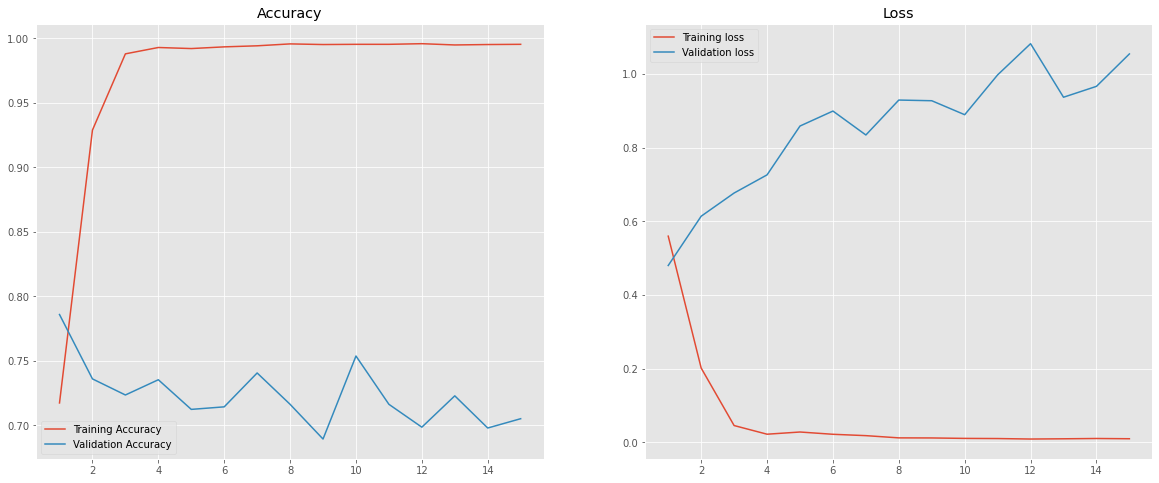

In [ ]:
epoch = range(1,  len(history_3)+1)
plt.figure(figsize = (20,8))

plt.subplot(121)
plt.title('Accuracy')
plt.plot(epoch, history_3['accuracy'], label = 'Training Accuracy')
plt.plot(epoch, history_3['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

plt.subplot(122)
plt.title('Loss')
plt.plot(epoch, history_3['loss'], label = 'Training loss')
plt.plot(epoch, history_3['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

EVALUATION

[0. 0. 1. ... 0. 1. 1.]
Predicted  0.0  1.0
Actual             
0          622  248
1          201  452


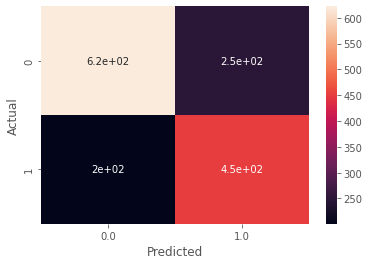

In [ ]:
from tensorflow.python.util.nest import flatten
y_pred = model.predict(X_test)
cutoff = 0.5                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes[y_pred > cutoff] = 1       # add a 1 if the cutoff was breached
 
y_pred_classes = y_pred_classes.flatten()
print(y_pred_classes)



confusion_matrix = pd.crosstab(y_test,y_pred_classes, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_classes)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_classes)
print('The accuracy of simpleRNN Bayes Model :  ', accuracy )

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_classes)
print('The recall of SimpleRNN Model :  ', recall )

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_classes)

print('The precision of simpleRNN Model :  ', precision )

# f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred_classes)

print('The f1_score of simpleRNN Model :  ', f1_score )

The accuracy of simpleRNN Bayes Model :   0.7051871306631649
The recall of SimpleRNN Model :   0.6921898928024502
The precision of simpleRNN Model :   0.6457142857142857
The f1_score of simpleRNN Model :   0.6681448632668144


#Model 3: LSTM

In [ ]:
# Create the model
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU,SimpleRNN

model = Sequential()
    
model.add(Embedding(vocab, embedding_vector_length, input_length=max_sentence_length))
model.add(LSTM(32, dropout=dropout, recurrent_dropout=dropout)),
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 210, 100)          2285300   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,302,357
Trainable params: 2,302,357
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(X_train,y_train,batch_size=10,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
609/609 - 147s - loss: 0.5295 - accuracy: 0.7346 - val_loss: 0.4311 - val_accuracy: 0.8142 - 147s/epoch - 241ms/step
Epoch 2/15
609/609 - 120s - loss: 0.2933 - accuracy: 0.8846 - val_loss: 0.4939 - val_accuracy: 0.7866 - 120s/epoch - 198ms/step
Epoch 3/15
609/609 - 131s - loss: 0.1616 - accuracy: 0.9369 - val_loss: 0.5647 - val_accuracy: 0.7656 - 131s/epoch - 216ms/step
Epoch 4/15
609/609 - 117s - loss: 0.0797 - accuracy: 0.9722 - val_loss: 0.6443 - val_accuracy: 0.7682 - 117s/epoch - 193ms/step
Epoch 5/15
609/609 - 105s - loss: 0.0453 - accuracy: 0.9852 - val_loss: 0.7211 - val_accuracy: 0.7663 - 105s/epoch - 172ms/step
Epoch 6/15
609/609 - 104s - loss: 0.0282 - accuracy: 0.9911 - val_loss: 0.8286 - val_accuracy: 0.7538 - 104s/epoch - 171ms/step
Epoch 7/15
609/609 - 104s - loss: 0.0208 - accuracy: 0.9924 - val_loss: 0.9506 - val_accuracy: 0.7269 - 104s/epoch - 170ms/step
Epoch 8/15
609/609 - 104s - loss: 0.0162 - accuracy: 0.9926 - val_loss: 1.0482 - val_accuracy: 0.7669 - 

In [ ]:
history_3 = pd.DataFrame(history.history)
history_3

,loss,accuracy,val_loss,val_accuracy
0,0.529462,0.734647,0.431098,0.814183
1,0.293261,0.884565,0.493871,0.786605
2,0.161631,0.936946,0.564688,0.765594
3,0.079724,0.972250,0.644252,0.768221
4,0.045273,0.985222,0.721096,0.766251
5,0.028162,0.991133,0.828560,0.753775
6,0.020759,0.992447,0.950552,0.726855
7,0.016161,0.992611,1.048217,0.766907
8,0.014680,0.993268,0.872787,0.759028
9,0.012967,0.995074,1.072239,0.760341


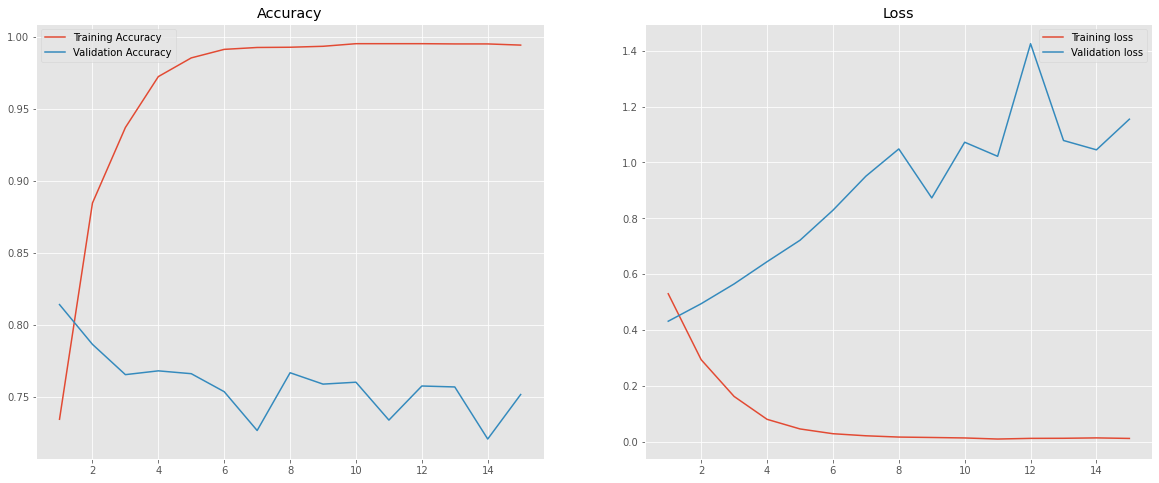

In [ ]:
epoch = range(1,  len(history_3)+1)
plt.figure(figsize = (20,8))

plt.subplot(121)
plt.title('Accuracy')
plt.plot(epoch, history_3['accuracy'], label = 'Training Accuracy')
plt.plot(epoch, history_3['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

plt.subplot(122)
plt.title('Loss')
plt.plot(epoch, history_3['loss'], label = 'Training loss')
plt.plot(epoch, history_3['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

Evaluation

[0. 1. 0. ... 0. 1. 1.]
Predicted  0.0  1.0
Actual             
0          711  148
1          230  434


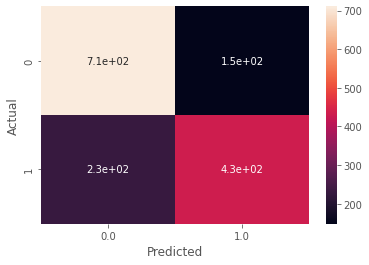

In [ ]:
from tensorflow.python.util.nest import flatten
y_pred = model.predict(X_test)
cutoff = 0.5                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes[y_pred > cutoff] = 1       # add a 1 if the cutoff was breached
 
y_pred_classes = y_pred_classes.flatten()
print(y_pred_classes)



confusion_matrix = pd.crosstab(y_test,y_pred_classes, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_classes)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_classes)
print('The accuracy of LSTM Model :  ', accuracy )

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_classes)
print('The recall of LSTM Model :  ', recall )

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_classes)

print('The precision of LSTM Model :  ', precision )

# f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred_classes)

print('The f1_score of LSTM Model :  ', f1_score )

The accuracy of LSTM Model :   0.7518056467498359
The recall of LSTM Model :   0.6536144578313253
The precision of LSTM Model :   0.7457044673539519
The f1_score of LSTM Model :   0.696629213483146


#Model4 : Bidirectional LSTM

In [ ]:

# Create the model
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU,SimpleRNN

model = Sequential()
    
model.add(Embedding(vocab, embedding_vector_length, input_length=max_sentence_length))
model.add(Bidirectional(LSTM(32, dropout=dropout, recurrent_dropout=dropout))),
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 210, 100)          2285300   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,319,413
Trainable params: 2,319,413
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(X_train,y_train,batch_size=10,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
609/609 - 124s - loss: 0.5302 - accuracy: 0.7368 - val_loss: 0.4579 - val_accuracy: 0.7859 - 124s/epoch - 203ms/step
Epoch 2/15
609/609 - 101s - loss: 0.3011 - accuracy: 0.8793 - val_loss: 0.4693 - val_accuracy: 0.7984 - 101s/epoch - 166ms/step
Epoch 3/15
609/609 - 102s - loss: 0.1587 - accuracy: 0.9379 - val_loss: 0.5368 - val_accuracy: 0.7814 - 102s/epoch - 168ms/step
Epoch 4/15
609/609 - 100s - loss: 0.0743 - accuracy: 0.9744 - val_loss: 0.7118 - val_accuracy: 0.7754 - 100s/epoch - 165ms/step
Epoch 5/15
609/609 - 101s - loss: 0.0468 - accuracy: 0.9842 - val_loss: 0.7855 - val_accuracy: 0.7669 - 101s/epoch - 166ms/step
Epoch 6/15
609/609 - 100s - loss: 0.0276 - accuracy: 0.9901 - val_loss: 0.8797 - val_accuracy: 0.7590 - 100s/epoch - 165ms/step
Epoch 7/15
609/609 - 100s - loss: 0.0180 - accuracy: 0.9938 - val_loss: 0.9508 - val_accuracy: 0.7603 - 100s/epoch - 164ms/step
Epoch 8/15
609/609 - 100s - loss: 0.0161 - accuracy: 0.9936 - val_loss: 1.1697 - val_accuracy: 0.7485 - 

[1. 1. 0. ... 0. 0. 1.]
Predicted  0.0  1.0
Actual             
0          614  234
1          273  402


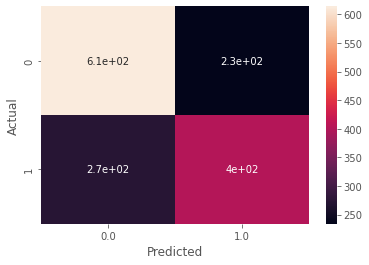

In [ ]:
from tensorflow.python.util.nest import flatten
y_pred = model.predict(X_test)
cutoff = 0.5                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes[y_pred > cutoff] = 1       # add a 1 if the cutoff was breached
 
y_pred_classes = y_pred_classes.flatten()
print(y_pred_classes)



confusion_matrix = pd.crosstab(y_test,y_pred_classes, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_classes)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_classes)
print('The accuracy of Bi_LSTM Model :  ', accuracy )

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_classes)
print('The recall of Bi_LSTM Model :  ', recall )

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_classes)

print('The precision of Bi_LSTM Model :  ', precision )

# f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred_classes)
print('The f1_score of Bi_LSTM Model :  ',f1_score  )


The accuracy of Bi_LSTM Model :   0.6671043992120814
The recall of Bi_LSTM Model :   0.5955555555555555
The precision of Bi_LSTM Model :   0.6320754716981132
The f1_score of Bi_LSTM Model :   0.6132723112128146


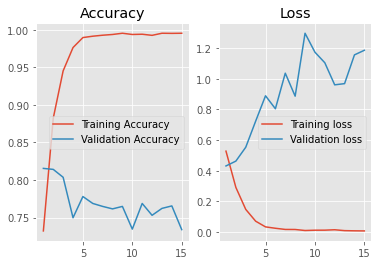

In [ ]:
plt.subplot(121)
plt.title('Accuracy')
plt.plot(epoch, history_4['accuracy'], label = 'Training Accuracy')
plt.plot(epoch, history_4['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

plt.subplot(122)
plt.title('Loss')
plt.plot(epoch, history_4['loss'], label = 'Training loss')
plt.plot(epoch, history_4['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

#Model 5: Gated Recurrent Unit

In [ ]:
# Create the model
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU,SimpleRNN

model = Sequential()
    
model.add(Embedding(vocab, embedding_vector_length, input_length=max_sentence_length))
model.add(GRU(64, dropout=dropout, recurrent_dropout=dropout)),
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 210, 100)          2285300   
                                                                 
 gru (GRU)                   (None, 64)                31872     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,317,237
Trainable params: 2,317,237
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(X_train,y_train,batch_size=10,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
609/609 - 124s - loss: 0.5494 - accuracy: 0.7230 - val_loss: 0.5164 - val_accuracy: 0.7892 - 124s/epoch - 203ms/step
Epoch 2/15
609/609 - 121s - loss: 0.3112 - accuracy: 0.8775 - val_loss: 0.4581 - val_accuracy: 0.8129 - 121s/epoch - 198ms/step
Epoch 3/15
609/609 - 120s - loss: 0.1454 - accuracy: 0.9445 - val_loss: 0.5751 - val_accuracy: 0.7886 - 120s/epoch - 198ms/step
Epoch 4/15
609/609 - 120s - loss: 0.0632 - accuracy: 0.9798 - val_loss: 0.6182 - val_accuracy: 0.7892 - 120s/epoch - 197ms/step
Epoch 5/15
609/609 - 120s - loss: 0.0353 - accuracy: 0.9880 - val_loss: 0.8109 - val_accuracy: 0.7859 - 120s/epoch - 197ms/step
Epoch 6/15
609/609 - 121s - loss: 0.0232 - accuracy: 0.9923 - val_loss: 0.7673 - val_accuracy: 0.7603 - 121s/epoch - 198ms/step
Epoch 7/15
609/609 - 120s - loss: 0.0201 - accuracy: 0.9939 - val_loss: 0.8815 - val_accuracy: 0.7827 - 120s/epoch - 198ms/step
Epoch 8/15
609/609 - 120s - loss: 0.0183 - accuracy: 0.9944 - val_loss: 0.8143 - val_accuracy: 0.7873 - 

In [ ]:
history_5 = pd.DataFrame(history.history)
history_5

,loss,accuracy,val_loss,val_accuracy
0,0.549361,0.722988,0.516415,0.789232
1,0.311241,0.877504,0.458059,0.812869
2,0.145379,0.944499,0.575090,0.788575
3,0.063191,0.979803,0.618196,0.789232
4,0.035286,0.988013,0.810894,0.785949
5,0.023164,0.992282,0.767255,0.760341
6,0.020129,0.993924,0.881454,0.782666
7,0.018337,0.994417,0.814314,0.787262
8,0.015345,0.994417,0.901145,0.760998
9,0.011440,0.995566,0.909220,0.774787


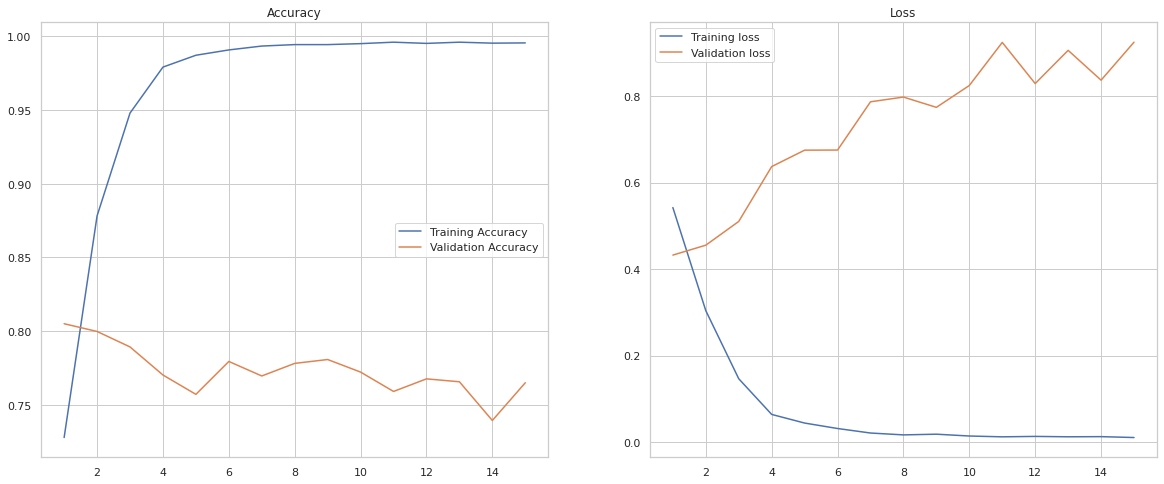

In [ ]:
epoch = range(1,  len(history_5)+1)
plt.figure(figsize = (20,8))

plt.subplot(121)
plt.title('Accuracy')
plt.plot(epoch, history_5['accuracy'], label = 'Training Accuracy')
plt.plot(epoch, history_5['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

plt.subplot(122)
plt.title('Loss')
plt.plot(epoch, history_5['loss'], label = 'Training loss')
plt.plot(epoch, history_5['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

Evaluation

[0. 0. 0. ... 1. 0. 1.]
Predicted  0.0  1.0
Actual             
0          772   95
1          260  396


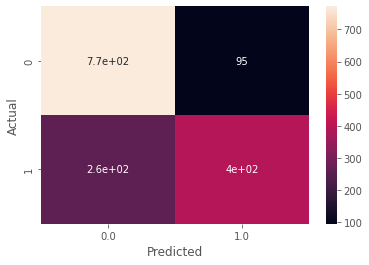

In [ ]:
from tensorflow.python.util.nest import flatten
y_pred = model.predict(X_test)
cutoff = 0.5                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes[y_pred > cutoff] = 1       # add a 1 if the cutoff was breached
 
y_pred_classes = y_pred_classes.flatten()
print(y_pred_classes)



confusion_matrix = pd.crosstab(y_test,y_pred_classes, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_classes)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_classes)
print('The accuracy of GRU Model :  ', accuracy )

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_classes)
print('The recall of GRU Model :  ', recall )

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_classes)

print('The precision of GRU Model :  ', precision )

# f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred_classes)

print('The f1_score of GRU Model :  ',f1_score  )

The accuracy of GRU Model :   0.7669074195666448
The recall of GRU Model :   0.6036585365853658
The precision of GRU Model :   0.8065173116089613
The f1_score of GRU Model :   0.6904969485614647


#model 6: LSTM with glove Embedding

In [ ]:
import os
import urllib.request
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.manifold import TSNE
import numpy as np

Downloading glove from stanford URL

In [ ]:
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

('glove.6B.zip', <http.client.HTTPMessage at 0x7f98ecb88fd0>)

In [ ]:
!unzip "/content/glove.6B.zip" -d "/content/"    # unziping the file

Archive:  /content/glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


In [ ]:
emmbed_dict = {}
with open('/content/glove.6B.100d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector
f.close

<function TextIOWrapper.close>

In [ ]:
def find_similar_word(emmbedes):
  nearest = sorted(emmbed_dict.keys(), key=lambda word: spatial.distance.euclidean(emmbed_dict[word], emmbedes))
  return nearest
#Now let’s find the top 10 similar words for the word ‘river’;

find_similar_word(emmbed_dict['river'])[0:10]


['river',
 'rivers',
 'creek',
 'lake',
 'danube',
 'valley',
 'basin',
 'flows',
 'canal',
 'estuary']

Visualising with TNSE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



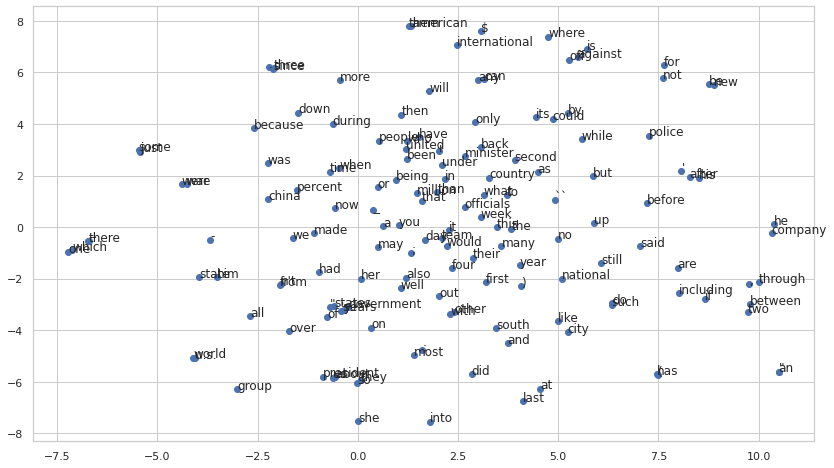

In [ ]:
distri = TSNE(n_components=2)
words = list(emmbed_dict.keys())
vectors = [emmbed_dict[word] for word in words]
y = distri.fit_transform(vectors[700:850])
plt.figure(figsize=(14,8))
plt.scatter(y[:, 0],y[:,1])
for label,x,y in zip(words,y[:, 0],y[:,1]):
  plt.annotate(label,xy=(x,y),xytext=(0,0),textcoords='offset points')
plt.show()

In [ ]:
import nltk
nltk.download('punkt')
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(train_df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if(word.isalpha()==1)]
        corpus.append(words)
    return corpus
corpus=create_corpus(train_df['text'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 7613/7613 [00:01<00:00, 4034.84it/s]


In [ ]:
vocab= len(total_vocabulary)
max_sentence_length = 210
embedding_vector_length = 100
dropout = 0.5
trunc_type= 'post'


# Tokenising to change the text to integers
tokenizer = Tokenizer(num_words = vocab)
tokenizer.fit_on_texts(train_df['text'])
sequences = tokenizer.texts_to_sequences(train_df['text'])
word_index = tokenizer.word_index
print(word_index)
print('Number of unique words:',len(word_index))


{'t': 1, 'co': 2, 'http': 3, 'the': 4, 'a': 5, 'in': 6, 'to': 7, 'of': 8, 'and': 9, 'i': 10, 'is': 11, 'for': 12, 'on': 13, 'you': 14, 'my': 15, 'it': 16, 'with': 17, 'that': 18, 'at': 19, 'by': 20, 'this': 21, 'from': 22, 'https': 23, 'be': 24, 'are': 25, 'was': 26, 'have': 27, 'like': 28, 'amp': 29, 'as': 30, 'up': 31, 'me': 32, 'just': 33, 'but': 34, 'so': 35, 'not': 36, 'your': 37, 'out': 38, 'no': 39, 'all': 40, 'after': 41, 'will': 42, 'has': 43, 'when': 44, 'an': 45, 'fire': 46, "i'm": 47, 'we': 48, 'if': 49, 'get': 50, 'new': 51, 'now': 52, 'via': 53, 'more': 54, '2': 55, 'about': 56, 'or': 57, 's': 58, 'news': 59, 'what': 60, 'one': 61, 'people': 62, 'they': 63, 'he': 64, 'how': 65, 'been': 66, 'over': 67, 'who': 68, "it's": 69, 'into': 70, "don't": 71, 'do': 72, 'can': 73, "'": 74, 'video': 75, 'disaster': 76, 'emergency': 77, 'there': 78, 'police': 79, 'than': 80, '3': 81, 'her': 82, 'u': 83, 'would': 84, 'his': 85, 'still': 86, 'some': 87, 'body': 88, 'were': 89, 'us': 90, 

Embedding Glove on Dataset

In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=emmbed_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
            

100%|██████████| 22331/22331 [00:00<00:00, 335611.05it/s]


In [ ]:
padded = pad_sequences(sequences, maxlen= max_sentence_length, truncating = trunc_type)
X_train, X_test, y_train, y_test = train_test_split(padded, train_df['target'].values, test_size=0.2)

In [ ]:
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU,SimpleRNN,GlobalMaxPool1D
model = Sequential()
    
model.add(Embedding(num_words, embedding_vector_length, embeddings_initializer=Constant(embedding_matrix), input_length=max_sentence_length, trainable=False))

model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])

model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 210, 100)          2233200   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 210, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 64)                42240     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,275,505
Trainable params: 42,305
Non-trainable params: 2,233,200
_________________________________________________________________


In [ ]:
history=model.fit(X_train,y_train,batch_size=10,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
609/609 - 106s - loss: 0.5103 - accuracy: 0.7544 - val_loss: 0.4465 - val_accuracy: 0.7965 - 106s/epoch - 173ms/step
Epoch 2/15
609/609 - 103s - loss: 0.4616 - accuracy: 0.7923 - val_loss: 0.4412 - val_accuracy: 0.7991 - 103s/epoch - 170ms/step
Epoch 3/15
609/609 - 104s - loss: 0.4446 - accuracy: 0.8010 - val_loss: 0.4351 - val_accuracy: 0.8004 - 104s/epoch - 170ms/step
Epoch 4/15
609/609 - 103s - loss: 0.4323 - accuracy: 0.8084 - val_loss: 0.4277 - val_accuracy: 0.8135 - 103s/epoch - 169ms/step
Epoch 5/15
609/609 - 103s - loss: 0.4197 - accuracy: 0.8115 - val_loss: 0.4227 - val_accuracy: 0.8102 - 103s/epoch - 170ms/step
Epoch 6/15
609/609 - 103s - loss: 0.4123 - accuracy: 0.8194 - val_loss: 0.4393 - val_accuracy: 0.7886 - 103s/epoch - 169ms/step
Epoch 7/15
609/609 - 103s - loss: 0.3975 - accuracy: 0.8299 - val_loss: 0.4247 - val_accuracy: 0.8050 - 103s/epoch - 170ms/step
Epoch 8/15
609/609 - 104s - loss: 0.3938 - accuracy: 0.8282 - val_loss: 0.4252 - val_accuracy: 0.8076 - 

In [ ]:
history_6 = pd.DataFrame(history.history)
history_6

,loss,accuracy,val_loss,val_accuracy
0,0.510328,0.754351,0.446528,0.796454
1,0.461560,0.792282,0.441212,0.799081
2,0.444554,0.800985,0.435096,0.800394
3,0.432285,0.808374,0.427728,0.813526
4,0.419668,0.811494,0.422732,0.810243
5,0.412280,0.819376,0.439297,0.788575
6,0.397522,0.829885,0.424694,0.804990
7,0.393781,0.828243,0.425152,0.807617
8,0.377453,0.832348,0.428039,0.810900
9,0.371857,0.842036,0.423015,0.807617


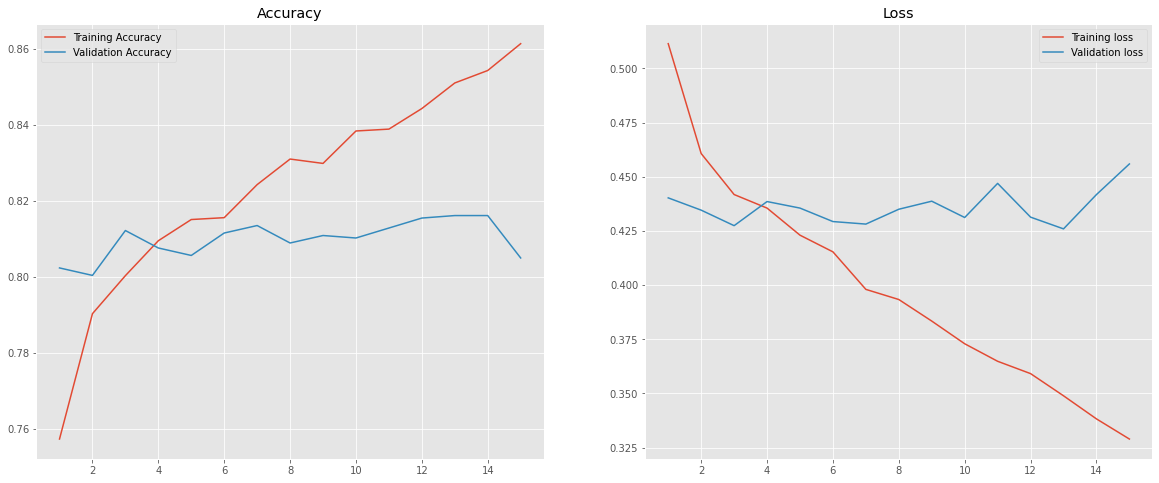

In [ ]:
epoch = range(1,  len(history_6)+1)
plt.figure(figsize = (20,8))

plt.subplot(121)
plt.title('Accuracy')
plt.plot(epoch, history_6['accuracy'], label = 'Training Accuracy')
plt.plot(epoch, history_6['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

plt.subplot(122)
plt.title('Loss')
plt.plot(epoch, history_6['loss'], label = 'Training loss')
plt.plot(epoch, history_6['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

Evaluation

Predicted  0.0  1.0
Actual             
0          812   36
1          278  397


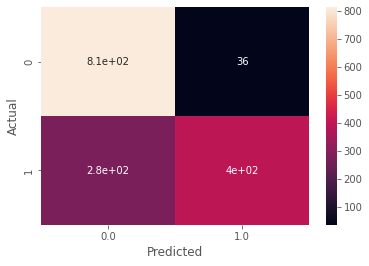

In [ ]:
from tensorflow.python.util.nest import flatten
y_pred = model.predict(X_test)
cutoff = 0.7                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes[y_pred > cutoff] = 1       # add a 1 if the cutoff was breached
 
y_pred_classes = y_pred_classes.flatten()



confusion_matrix = pd.crosstab(y_test,y_pred_classes, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:

# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_classes)

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_classes)
print('The recall of LSTM Model glove  :  ', recall )

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_classes)

print('The precision of LSTM Model with glove  :  ', precision )

# f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred_classes)

print('The f1_score of LSTM Model with glove  :  ', f1_score)

The recall of LSTM Model glove  :   0.5881481481481482
The precision of LSTM Model with glove  :   0.9168591224018475
The f1_score of LSTM Model with glove  :   0.7166064981949459


#Model 7: LSTM with Glove and Deep Neural Network

In [ ]:
import os
import urllib.request
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.manifold import TSNE
import numpy as np

Downloading glove from stanford url

In [ ]:
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

('glove.6B.zip', <http.client.HTTPMessage at 0x7f4db6e41610>)

In [ ]:
!unzip "/content/glove.6B.zip" -d "/content/"  #  unzipping the file

Archive:  /content/glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


In [ ]:
emmbed_dict = {}
with open('/content/glove.6B.100d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector
f.close

<function TextIOWrapper.close>

Embedding glove on the dataset

In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=emmbed_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 22331/22331 [00:00<00:00, 460937.71it/s]


In [ ]:
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU,SimpleRNN,GlobalMaxPool1D
model = Sequential()
    
model.add(Embedding(num_words, embedding_vector_length, embeddings_initializer=Constant(embedding_matrix), input_length=max_sentence_length, trainable=False))

model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 210, 100)          2233200   
                                                                 
 spatial_dropout1d (SpatialD  (None, 210, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                3250      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                      

In [ ]:
history=model.fit(X_train,y_train,batch_size=10,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
609/609 - 117s - loss: 0.5799 - accuracy: 0.6985 - val_loss: 0.4327 - val_accuracy: 0.8135 - 117s/epoch - 192ms/step
Epoch 2/15
609/609 - 110s - loss: 0.5194 - accuracy: 0.7700 - val_loss: 0.4145 - val_accuracy: 0.8286 - 110s/epoch - 181ms/step
Epoch 3/15
609/609 - 110s - loss: 0.4902 - accuracy: 0.7867 - val_loss: 0.4256 - val_accuracy: 0.8234 - 110s/epoch - 181ms/step
Epoch 4/15
609/609 - 112s - loss: 0.4770 - accuracy: 0.7862 - val_loss: 0.4115 - val_accuracy: 0.8372 - 112s/epoch - 184ms/step
Epoch 5/15
609/609 - 110s - loss: 0.4666 - accuracy: 0.7936 - val_loss: 0.4068 - val_accuracy: 0.8313 - 110s/epoch - 180ms/step
Epoch 6/15
609/609 - 109s - loss: 0.4660 - accuracy: 0.7982 - val_loss: 0.4095 - val_accuracy: 0.8345 - 109s/epoch - 180ms/step
Epoch 7/15
609/609 - 111s - loss: 0.4510 - accuracy: 0.7982 - val_loss: 0.4223 - val_accuracy: 0.8240 - 111s/epoch - 182ms/step
Epoch 8/15
609/609 - 110s - loss: 0.4435 - accuracy: 0.8067 - val_loss: 0.4188 - val_accuracy: 0.8214 - 

In [ ]:
history_7 = pd.DataFrame(history.history)
history_7

,loss,accuracy,val_loss,val_accuracy
0,0.579941,0.698522,0.432746,0.813526
1,0.519367,0.769951,0.414462,0.828628
2,0.490169,0.786700,0.425596,0.823375
3,0.476951,0.786207,0.411489,0.837164
4,0.466626,0.793596,0.406751,0.831254
5,0.466036,0.798194,0.409488,0.834537
6,0.451011,0.798194,0.422320,0.824032
7,0.443540,0.806732,0.418790,0.821405
8,0.442816,0.808374,0.406508,0.825345
9,0.422970,0.815764,0.408702,0.829941


Predicted  0.0  1.0
Actual             
0          831   60
1          200  432


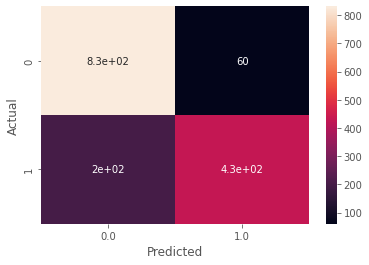

In [ ]:

y_pred = model.predict(X_test)
cutoff = 0.7                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes[y_pred > cutoff] = 1       # add a 1 if the cutoff was breached
 
y_pred_classes = y_pred_classes.flatten()



confusion_matrix = pd.crosstab(y_test,y_pred_classes, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_classes)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_classes)
print('The accuracy of of deep LSTM+glove Model :  ', accuracy )

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_classes)
print('The recall of deep LSTM + glove  Model :  ', recall )

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_classes)

print('The precision of deep LSTM + glove  Model :  ', precision )

# f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred_classes)

print('The f1_score of deep LSTM + glove Model :  ', f1_score )

The accuracy of of deep LSTM+glove Model :   0.8292843072882469
The recall of deep LSTM + glove  Model :   0.6835443037974683
The precision of deep LSTM + glove  Model :   0.8780487804878049
The f1_score of deep LSTM + glove Model :   0.7686832740213523


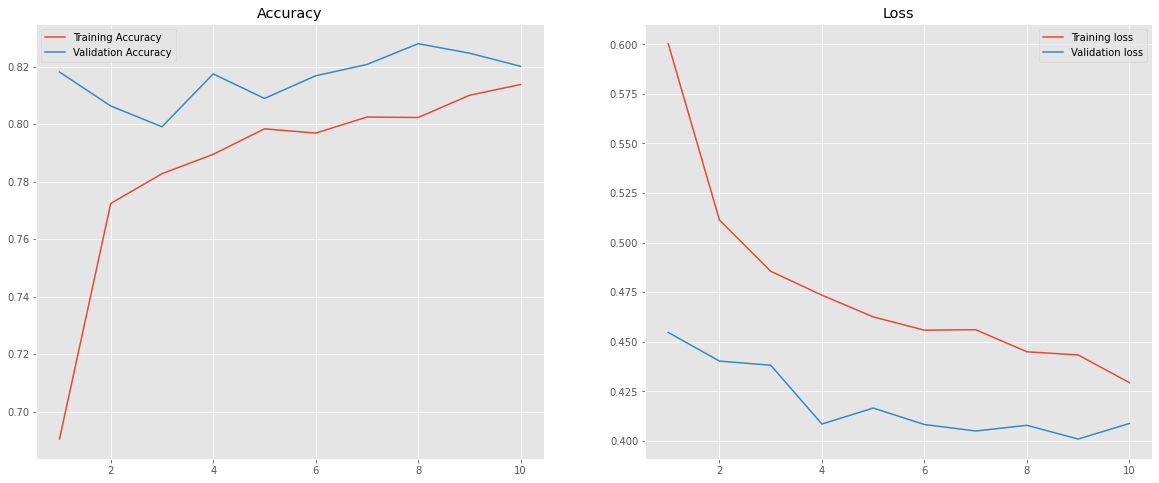

In [ ]:
epoch = range(1,  len(history_7)+1)
plt.figure(figsize = (20,8))

plt.subplot(121)
plt.title('Accuracy')
plt.plot(epoch, history_7['accuracy'], label = 'Training Accuracy')
plt.plot(epoch, history_7['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

plt.subplot(122)
plt.title('Loss')
plt.plot(epoch, history_7['loss'], label = 'Training loss')
plt.plot(epoch, history_7['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()